## Value wrapper for building expressions with gradients and backpropogation (Neurons)

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # gradient
    self._backward = lambda: None # backward function for backpropogation (sets gradients)
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self, ), f"**{other}")
    def _backward():
      self.grad += other * self.data**(other-1) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1

    for node in reversed(topo):
      node._backward()



## functions for printing graphs

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## how neurons are modeled in machine learning

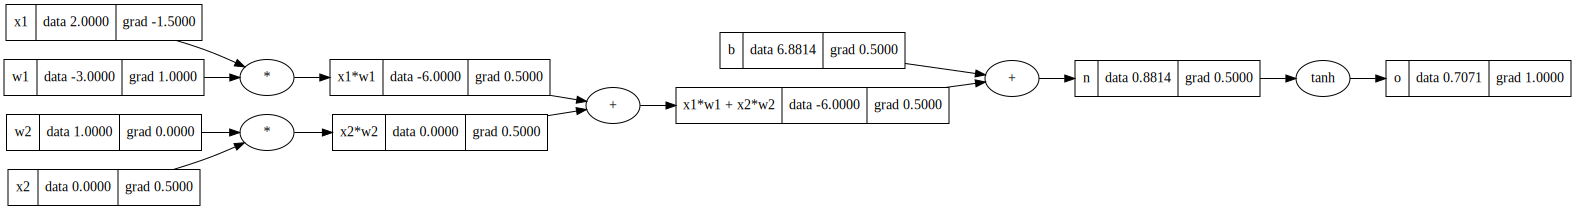

In [ ]:
# how neurons are modeled in machine learning

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

## Doing the same thing but in pytorch with tensors

In [ ]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Building out Neural Network classes

In [ ]:
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP: # mulit-layer perceptron
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  # returns all weights and biases in the network
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


## Neural Network Training Example

In [ ]:
n = MLP(3, [4, 4, 1]) # this is our neural network ( 3 inputs, two hidden layers with four neurons each, 1 output neuron)
xs = [                # this is the input data
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # these are the desired outputs

ypred = [n(x) for x in xs] # these are the predictions that our neural network makes, they are wron because it has not been tuned or trained in any way
# mean squared error loss
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
# we want to minimize loss. The greater the loss, the worse the neural network
loss.backward() # backprogogate and calculate gradients
#draw_dot(loss)
# we do this by nudging the parameters in the direction that will most effectively minimize the loss function according to the gradients
for p in n.parameters():
  p.data += -0.01 * p.grad
#print(n.parameters())

In [ ]:
# gradient descent/training loop
for k in range(100):
  # forward pass
  ypred = [n(x) for x in xs] # these are the predictions that our neural network makes, they are wron because it has not been tuned or trained in any way
  # mean squared error loss
  loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])

  # backward pass
  # we want to minimize loss. The greater the loss, the worse the neural network
  for p in n.parameters(): # zero grad, very important
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad # nudges the parameters in the direction that will most effectively minimize the loss function according to the gradients


print('loss', loss)
print('prdeictions', ypred)

loss Value(data=0.00011633223099107117)
prdeictions [Value(data=0.9961236040249389), Value(data=-0.9930870725584908), Value(data=-0.9957729698954028), Value(data=0.9940292851417222)]


In [ ]:
# the wights and parameters that the training has pushed the network to
print(n.parameters())

[Value(data=0.10996355248688762), Value(data=0.5349427755309406), Value(data=-0.34884482294478636), Value(data=-0.507839903622925), Value(data=0.6521031033001038), Value(data=-0.015826755201057655), Value(data=-0.7841154870361869), Value(data=0.42677853022966467), Value(data=-0.8068417420409651), Value(data=-0.8143862764501298), Value(data=-0.7227157746181302), Value(data=-0.9089589883025009), Value(data=-0.15846812530607177), Value(data=0.2952674990435828), Value(data=-1.3371627918634832), Value(data=-0.05401137341508317), Value(data=0.5402651472088922), Value(data=-0.2623815251462708), Value(data=-0.409691763536351), Value(data=1.3691684907466533), Value(data=-0.5706401903387005), Value(data=-0.4504356371104356), Value(data=-0.8653633066337889), Value(data=-0.249558791014133), Value(data=-0.05623894221968762), Value(data=-0.7326056726796827), Value(data=0.15061397371987958), Value(data=0.9246650202148538), Value(data=0.9834122840319663), Value(data=1.0612506627871416), Value(data=0.0

In [2]:
import numpy as np
import pandas as pd
# from matplotlib import pyplot as plt

data = pd.read_csv('mnist_train.csv')
# print(data.head())

data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
y_dev = data_dev[0]
x_dev = data_dev[1:n]

data_train = data[1000:m].T
y_train = data_train[0]
x_train = data_train[1:n]


def init_params():
    w1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    w2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return w1, b1, w2, b2


def relu(z):
    return np.maximum(z, 0)


def drelu(z):
    return z > 0


def softmax(z):
    return (np.exp(z))/np.sum(np.exp(z))


def forward(w1, b1, w2, b2, x):
    z1 = w1.dot(x) + b1
    a1 = relu(z1)
    z2 = w2.dot(a1) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2


def one_hot(y):
    one_hot_y = np.zeros((y.size, y.max() + 1))
    one_hot_y[np.arange(y.size), y] = 1
    one_hot_y = one_hot_y.T
    return one_hot_y


def backward(z1, a1, z2, a2, w2, x, y):
    m = y.size
    one_hot_y = one_hot(y)
    dz2 = a2 - one_hot_y
    dw2 = 1/m * dz2.dot(a1.T)
    db2 = 1/m * np.sum(dz2)
    dz1 = w2.T.dot(dz2) * drelu(z1)
    dw1 = 1/m * dz1.dot(x.T)
    db1 = 1/m * np.sum(dz1)
    return dw1, db1, dw2, db2


def update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha):
    w1 = w1 - alpha*dw1
    b1 = b1 - alpha*db1
    w2 = w2 - alpha*dw2
    b2 = b2 - alpha*db2
    w1 = w1 - alpha*dw1
    return w1, b1, w2, b2


def get_predictions(a):
    return np.argmax(a, 0)


def get_accuracy(preds, y):
    print(preds, y)
    return np.sum(preds == y) / y.size


def gradient_descent(x, y, iterations, alpha):
    w1, b1, w2, b2 = init_params()
    for i in range(iterations):
        z1, a1, z2, a2 = forward(w1, b1, w2, b2, x)
        dw1, db1, dw2, db2 = backward(z1, a1, z2, a2, w2, x, y)
        w1, b1, w2, b2 = update_params(
            w1, b1, w2, b2, dw1, db1, dw2, db2, alpha)
        if i % 10 == 0:
            print("iteration:", i)
            print("accuracy:", get_accuracy(get_predictions(a2), y))
    return w1, b1, w2, b2


w1, b1, w2, b2 = gradient_descent(x_train, y_train, 210, 0.1)


<ipython-input-2-1f4b1a09df1d>:38: RuntimeWarning: overflow encountered in exp
  return (np.exp(z))/np.sum(np.exp(z))


TypeError: ignored